# Exercise 1: Web Scraping, Portfolio Analysis & Visualization

## Part 1: Web Scraping Top Stock Gainers from Yahoo Finance

In [1]:
import time
import re
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException, NoSuchElementException

URL = "https://finance.yahoo.com/markets/stocks/gainers/"
TIMEOUT = 15
TARGET = 50

def make_driver(headless=False):
    opts = webdriver.ChromeOptions()
    if headless:
        opts.add_argument("--headless=new")
    opts.add_argument("--start-maximized")
    opts.add_argument("--disable-notifications")
    return webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=opts)

def click_if_present(driver, xpath, wait_s=5):
    try:
        el = WebDriverWait(driver, wait_s).until(EC.element_to_be_clickable((By.XPATH, xpath)))
        try:
            el.click()
        except ElementClickInterceptedException:
            driver.execute_script("arguments[0].click()", el)
        return True
    except TimeoutException:
        return False

def accept_cookies(driver):
    # Botones típicos de consentimiento
    for xp in [
        "//button[contains(., 'Accept all')]",
        "//button[contains(., 'Agree')]",
        "//button[contains(., 'Aceptar todo')]",
        "//button[contains(translate(., 'ACEPTAR', 'aceptar'),'aceptar')]",
    ]:
        if click_if_present(driver, xp, wait_s=4):
            break

def wait_first_rows(driver):
    WebDriverWait(driver, TIMEOUT).until(
        EC.presence_of_element_located((By.XPATH, "//a[contains(@href,'/quote/') and not(contains(@href,'/news/'))]"))
    )

def try_show_more(driver):
    # Clic en "Show more" si existe (varía por layout)
    clicked = False
    for _ in range(2):  # dos intentos por si carga en lotes de 25
        ok = click_if_present(driver, "//button[contains(., 'Show more') or contains(., 'Show More')]", wait_s=5)
        if ok:
            clicked = True
            time.sleep(1.0)
        else:
            break
    return clicked

def open_rows_menu(driver):
    # Abre el dropdown "Rows per page"
    # 1) botón cerca de texto 'Rows per page'
    if click_if_present(driver, "//div[contains(., 'Rows per page')]//button[@aria-haspopup='listbox']", wait_s=5):
        return True
    # 2) botón genérico con aria-label=25/50
    if click_if_present(driver, "//button[@aria-haspopup='listbox' and (@aria-label='25' or @aria-label='50')]", wait_s=5):
        return True
    # 3) fallback por clase 'menuBtn'
    return click_if_present(driver, "//button[contains(@class,'menuBtn') and @aria-haspopup='listbox']", wait_s=5)

def select_50_rows(driver):
    # Tras abrir el menú, el ítem "50" puede ser <span>, <li> o <button>
    for xp in [
        "//span[.='50' or .='50 rows']",
        "//li[.='50']",
        "//button[.='50' or .='50 rows']",
        "//*[@role='option' and (text()='50' or text()='50 rows')]",
    ]:
        if click_if_present(driver, xp, wait_s=5):
            time.sleep(1.0)
            return True
    return False

def get_pairs_from_visible(driver):
    pairs = []
    seen = set()

    # Preferir tabla clásica
    rows = driver.find_elements(By.XPATH, "//table//tbody/tr[.//a[contains(@href,'/quote/')]]")
    if not rows:
        # Variante grid ARIA
        rows = driver.find_elements(By.XPATH, "//*[@role='row'][.//a[contains(@href,'/quote/')]]")

    for r in rows:
        sym = ""
        name = ""
        try:
            link = r.find_element(By.XPATH, ".//a[contains(@href,'/quote/')]")
            sym = (link.text or "").strip()
        except NoSuchElementException:
            continue

        if not re.fullmatch(r"[A-Za-z0-9\.\-^]{1,10}", sym or ""):
            continue

        # Nombre: intentar la segunda celda
        try:
            # tabla
            name = r.find_element(By.XPATH, ".//td[2]").text.strip()
        except Exception:
            try:
                # grid
                name = r.find_element(By.XPATH, ".//*[@role='cell'][2]").text.strip()
            except Exception:
                name = ""

        if sym and sym not in seen:
            pairs.append((sym, name))
            seen.add(sym)

    return pairs

def click_next_page_if_any(driver):
    # Usa botón data-testid="next-page-button" si está habilitado
    try:
        btn = driver.find_element(By.XPATH, "//button[@data-testid='next-page-button']")
        disabled = btn.get_attribute("disabled")
        if disabled:
            return False
        try:
            btn.click()
        except ElementClickInterceptedException:
            driver.execute_script("arguments[0].click()", btn)
        time.sleep(1.0)
        return True
    except NoSuchElementException:
        return False

def main():
    driver = make_driver(headless=False)
    try:
        driver.get(URL)
        accept_cookies(driver)
        wait_first_rows(driver)

        # 1) Clic en SHOW MORE (si existe)
        try_show_more(driver)

        # 2) Abrir "Rows per page" y elegir 50 (si existe)
        if open_rows_menu(driver):
            select_50_rows(driver)

        # 3) Recolectar hasta 50 (combinando página actual + paginación si hace falta)
        collected = {}
        for page_num in range(5):  # hasta 5 páginas como máximo
            pairs = get_pairs_from_visible(driver)
            print(f"Página {page_num + 1}: Encontrados {len(pairs)} pares")
            for sym, name in pairs:
                collected.setdefault(sym, name)
                if len(collected) >= TARGET:
                    break
            print(f"Total recolectado hasta ahora: {len(collected)}")
            if len(collected) >= TARGET:
                break
            # si aún no llegamos a 50, intenta pasar a la siguiente página
            if not click_next_page_if_any(driver):
                print("No hay más páginas disponibles.")
                break

        # 4) DataFrame y (opcional) CSV
        items = list(collected.items())[:TARGET]
        df = pd.DataFrame(items, columns=["Symbol", "Name"])
        print(df.head(10))
        df.to_csv("top_gainers_50.csv", index=False)

        # Para que veas la cantidad final
        print(f"\nFilas obtenidas: {len(df)}")

    finally:
        driver.quit()

if __name__ == "__main__":
    main()

Página 1: Encontrados 50 pares
Total recolectado hasta ahora: 50
  Symbol                           Name
0   AMBA                Ambarella, Inc.
1   IREN                   IREN Limited
2   BABA  Alibaba Group Holding Limited
3   AFRM          Affirm Holdings, Inc.
4   DOOO                       BRP Inc.
5   ADSK                 Autodesk, Inc.
6   CIFR             Cipher Mining Inc.
7   SATS           EchoStar Corporation
8      S              SentinelOne, Inc.
9    EQX             Equinox Gold Corp.

Filas obtenidas: 50


In [22]:
top_gainers = pd.read_csv("top_gainers_50.csv")
top_gainers.head(50)

,Symbol,Name
0,AMBA,"Ambarella, Inc."
1,IREN,IREN Limited
2,BABA,Alibaba Group Holding Limited
3,AFRM,"Affirm Holdings, Inc."
4,DOOO,BRP Inc.
5,ADSK,"Autodesk, Inc."
6,CIFR,Cipher Mining Inc.
7,SATS,EchoStar Corporation
8,S,"SentinelOne, Inc."
9,EQX,Equinox Gold Corp.


## Part 2: Historical Data Retrieval 

In [ ]:
import yfinance as yf

# Get symbols from top_gainers DataFrame
symbols = top_gainers["Symbol"].tolist()

# Download historical data
data = yf.download(
    tickers=symbols,
    period="1y",
    interval="1mo",
    group_by="ticker",
    auto_adjust=False,
    threads=True,
    progress=False
)

# Extract Adjusted Close prices
adj_close = data.xs('Adj Close', axis=1, level=1)

# Make index tz-naive
adj_close.index = adj_close.index.tz_localize(None)

# Keep last 13 months, then take the first 12 (excluding the most recent/current month)
prices = adj_close.tail(13).head(12)

In [26]:
prices.to_csv("close_prices.csv", index=True) # Lo descargo en CSV para evitar tener que volver a correr el código por los límites
prices.head(12)

Ticker,AEM,PRVA,IAG,BF-B,HCC,BILI,SOUN,EMN,OS,WPM,...,BF-A,HL,CNXC,S,FSM,UPWK,BHC,BTU,BTDR,GFI
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-01,79.566811,18.209999,5.23,48.019775,63.518719,23.379999,4.66,107.977699,33.900002,60.682819,...,46.925606,6.639760,49.956009,23.920000,4.63,10.450000,8.16,26.100916,7.83,14.890774
2024-10-01,85.226173,18.360001,5.54,43.180271,62.753311,22.120001,5.03,102.163742,29.520000,65.580757,...,42.737293,6.460576,41.436684,25.790001,4.97,13.560000,9.20,25.835382,7.79,16.182167
2024-11-01,83.379219,21.480000,5.50,41.267910,69.900421,19.170000,9.31,101.804054,29.889999,61.924690,...,40.560219,5.494973,44.135979,27.950001,4.78,16.969999,8.37,23.455421,14.27,14.228132
2024-12-01,77.617378,19.549999,5.16,37.247028,53.982235,18.110001,19.84,88.777184,28.520000,56.012188,...,36.961185,4.899924,42.486404,22.200001,4.29,16.350000,8.06,20.649555,21.67,12.961446
2025-01-01,92.235771,22.850000,6.24,32.535694,52.519222,16.719999,14.15,97.698471,29.780001,62.216953,...,32.840946,5.668343,51.333233,23.950001,5.07,15.760000,7.43,17.898254,18.52,16.624037
2025-02-01,95.550461,24.969999,5.52,32.634262,47.911224,20.340000,10.82,95.933723,23.299999,68.640823,...,32.555115,5.119473,44.619957,20.629999,4.32,15.930000,7.44,13.598727,12.31,17.645241
2025-03-01,108.043045,22.450001,6.25,33.452332,47.575581,19.110001,8.12,86.384468,21.340000,77.315536,...,32.988792,5.548589,54.974628,18.180000,6.10,13.050000,6.47,13.425584,8.83,21.690783
2025-04-01,117.181999,23.480000,7.08,34.558651,47.675278,17.500000,9.29,76.190498,21.400000,83.181679,...,34.330509,5.712469,50.449402,18.500000,6.25,13.150000,5.30,12.226694,9.57,22.540001
2025-05-01,117.590607,22.760000,6.86,33.070766,45.312454,18.299999,10.11,77.546097,28.059999,86.582626,...,32.961655,5.133233,55.658379,17.610001,5.85,15.490000,4.53,13.039165,12.86,23.000000


## Part 3: Portfolio Construction & Analysis 

In [7]:
close_prices = pd.read_csv("close_prices.csv", index_col=0)

In [ ]:
# Clean data - remove stocks with missing values (solo hay dos stocks con missing data)
prices_clean = close_prices.dropna(axis=1)

# Split data into first 6 months (for portfolio selection) and last 6 months (for analysis)
first_6_months = prices_clean.iloc[:6]  # September 2024 to February 2025
last_6_months = prices_clean.iloc[6:]   # March 2025 to August 2025

### a) Cumulative returns in first 6 months (PORTFOLIO SELECTION STRATEGY)

In [15]:
# PORTFOLIO SELECTION STRATEGY: Top 10 stocks with highest cumulative return in first 6 months

# Calculate cumulative return for first 6 months for each stock
first_month_prices = first_6_months.iloc[0]  # September 2024
last_month_prices = first_6_months.iloc[-1]  # February 2025

# Calculate cumulative return: (End Price - Start Price) / Start Price
cumulative_returns_first_6m = (last_month_prices - first_month_prices) / first_month_prices

# Sort by cumulative return in descending order and select top 10
top_10_stocks = cumulative_returns_first_6m.sort_values(ascending=False).head(10)

print("PORTFOLIO SELECTION RESULTS")
print("="*50)
print("Strategy: Select top 10 stocks with highest cumulative return in first 6 months")
print(f"Selection period: {pd.to_datetime(first_6_months.index[0]).strftime('%B %Y')} to {pd.to_datetime(first_6_months.index[-1]).strftime('%B %Y')}")
print("\nSelected 10-stock portfolio:")
print("-"*30)

for i, (stock, cum_return) in enumerate(top_10_stocks.items(), 1):
    print(f"{i:2d}. {stock:5s} - Cumulative Return: {cum_return:7.1%}")

portfolio_stocks = list(top_10_stocks.index)
print(f"\nPortfolio stocks: {portfolio_stocks}")
print("Portfolio assumption: Equal-weighted (10% allocation to each stock)")

PORTFOLIO SELECTION RESULTS
Strategy: Select top 10 stocks with highest cumulative return in first 6 months
Selection period: September 2024 to February 2025

Selected 10-stock portfolio:
------------------------------
 1. SOUN  - Cumulative Return:  132.2%
 2. GH    - Cumulative Return:   85.5%
 3. SSRM  - Cumulative Return:   75.9%
 4. BTDR  - Cumulative Return:   57.2%
 5. AFRM  - Cumulative Return:   57.2%
 6. UPWK  - Cumulative Return:   52.4%
 7. PRVA  - Cumulative Return:   37.1%
 8. JOYY  - Cumulative Return:   29.1%
 9. SATS  - Cumulative Return:   25.8%
10. BABA  - Cumulative Return:   24.9%

Portfolio stocks: ['SOUN', 'GH', 'SSRM', 'BTDR', 'AFRM', 'UPWK', 'PRVA', 'JOYY', 'SATS', 'BABA']
Portfolio assumption: Equal-weighted (10% allocation to each stock)


### b) Returns in the last 6 months (PERFORMANCE ANALYSIS)

In [19]:
# PERFORMANCE ANALYSIS: Last 6 months (March 2025 to August 2025)

print("PERFORMANCE ANALYSIS - LAST 6 MONTHS")
print("="*50)
print(f"Analysis period: {pd.to_datetime(last_6_months.index[0]).strftime('%B %Y')} to {pd.to_datetime(last_6_months.index[-1]).strftime('%B %Y')}")

# Extract portfolio stock prices for last 6 months
portfolio_prices = last_6_months[portfolio_stocks]

# Calculate monthly percentage returns for individual stocks
monthly_returns_individual = portfolio_prices.pct_change().dropna()

print("\n1. INDIVIDUAL STOCK MONTHLY RETURNS (%)")
print("-"*45)
print(monthly_returns_individual.round(4) * 100)

# Calculate portfolio monthly returns (equal-weighted)
# Portfolio return = average of individual stock returns (since equal-weighted)
monthly_returns_portfolio = monthly_returns_individual.mean(axis=1)

print(f"\n2. PORTFOLIO MONTHLY RETURNS (%) - Equal-weighted")
print("-"*50)
for date, return_val in monthly_returns_portfolio.items():
    print(f"{pd.to_datetime(date).strftime('%B %Y'):12s}: {return_val:7.2%}")

# Summary statistics
print(f"\n3. SUMMARY STATISTICS - LAST 6 MONTHS")
print("-"*40)
print(f"Average monthly portfolio return: {monthly_returns_portfolio.mean():7.2%}")
print(f"Portfolio volatility (std dev):  {monthly_returns_portfolio.std():7.2%}")
print(f"Best month:  {monthly_returns_portfolio.max():7.2%} ({pd.to_datetime(monthly_returns_portfolio.idxmax()).strftime('%B %Y')})")
print(f"Worst month: {monthly_returns_portfolio.min():7.2%} ({pd.to_datetime(monthly_returns_portfolio.idxmin()).strftime('%B %Y')})")

# Cumulative return for the entire last 6 months period
cumulative_portfolio_return = (1 + monthly_returns_portfolio).prod() - 1
print(f"Total cumulative return (last 6 months): {cumulative_portfolio_return:7.2%}")

PERFORMANCE ANALYSIS - LAST 6 MONTHS
Analysis period: March 2025 to August 2025

1. INDIVIDUAL STOCK MONTHLY RETURNS (%)
---------------------------------------------
             SOUN     GH   SSRM   BTDR   AFRM   UPWK   PRVA   JOYY   SATS  \
Date                                                                        
2025-04-01  14.41  10.87   6.08   8.38  10.11   0.77   4.59  -1.95 -12.12   
2025-05-01   8.83 -14.00  11.18  34.38   4.30  17.79  -3.07  19.08 -21.13   
2025-06-01   6.13  28.11   7.69 -10.73  33.22 -13.23   1.05   6.33  56.23   
2025-07-01  -3.73 -21.25  -6.20  12.28  -0.84 -11.01 -15.13   0.50  17.65   
2025-08-01  26.04  64.52  61.59  10.86  29.03  28.68  18.03   7.69  89.60   

             BABA  
Date               
2025-04-01  -9.68  
2025-05-01  -4.68  
2025-06-01  -0.38  
2025-07-01   8.16  
2025-08-01  11.91  

2. PORTFOLIO MONTHLY RETURNS (%) - Equal-weighted
--------------------------------------------------
April 2025  :   3.15%
May 2025    :   5.27%
June 20

### c) Visualization

4. RISK-RETURN ANALYSIS & VISUALIZATION
Portfolio Risk (Monthly Volatility): 14.39%
Portfolio Return (Average Monthly):  10.54%
Annualized Portfolio Return:         126.47%
Annualized Portfolio Risk:           49.83%


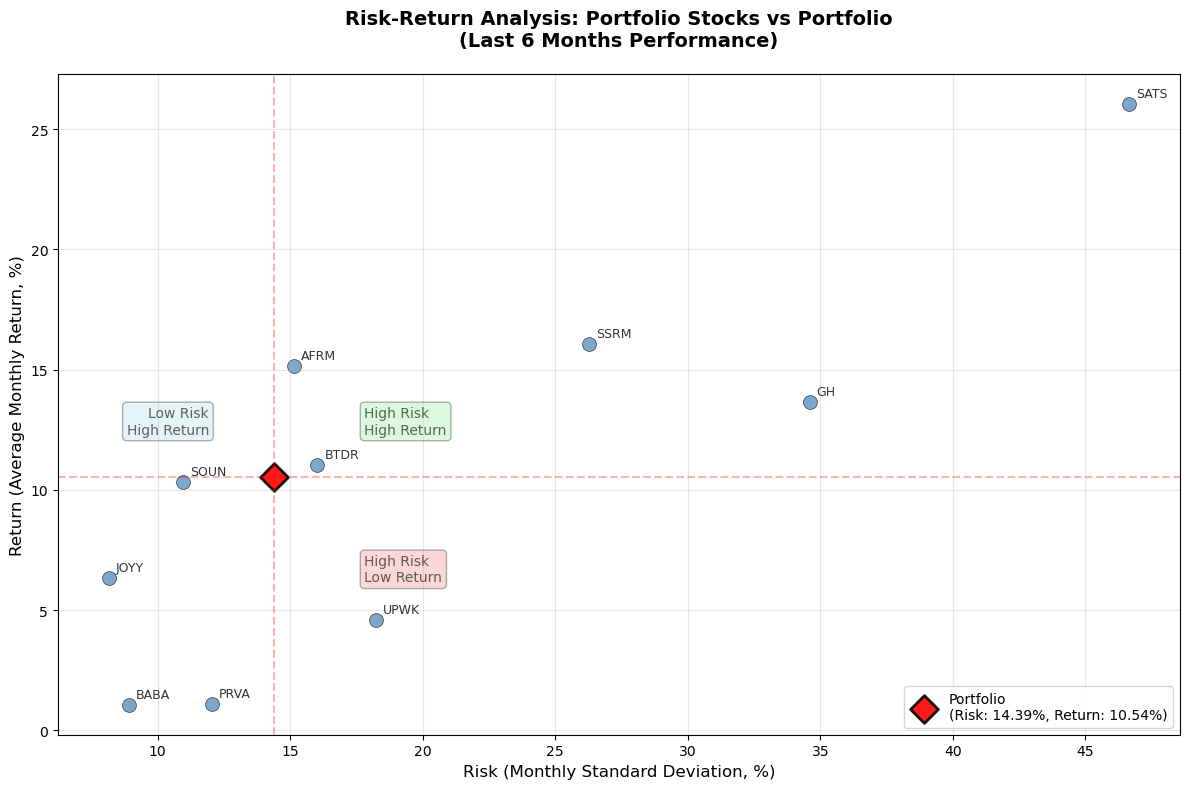


5. INDIVIDUAL STOCK RISK-RETURN SUMMARY
-------------------------------------------------------
Stock  Return (%)   Risk (%)   Risk/Return 
-------------------------------------------------------
SOUN   10.34        10.97      1.06        
GH     13.65        34.59      2.53        
SSRM   16.07        26.28      1.64        
BTDR   11.03        16.03      1.45        
AFRM   15.16        15.15      1.00        
UPWK   4.60         18.24      3.97        
PRVA   1.10         12.04      10.99       
JOYY   6.33         8.17       1.29        
SATS   26.05        46.64      1.79        
BABA   1.07         8.92       8.36        
-------------------------------------------------------
PORTFOLIO 10.54        14.39      1.36        

6. PERFORMANCE HIGHLIGHTS
------------------------------
Best performing stock:  SATS (26.05%)
Worst performing stock: BABA (1.07%)
Lowest risk stock:      JOYY (8.17%)
Highest risk stock:     SATS (46.64%)


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# RISK-RETURN VISUALIZATION
print("4. RISK-RETURN ANALYSIS & VISUALIZATION")
print("="*45)

# Calculate risk (standard deviation) and return (mean) for each stock in the portfolio
individual_returns = monthly_returns_individual.mean() * 100  # Convert to percentage
individual_risks = monthly_returns_individual.std() * 100     # Convert to percentage

# Portfolio metrics
portfolio_return = monthly_returns_portfolio.mean() * 100
portfolio_risk = monthly_returns_portfolio.std() * 100

print(f"Portfolio Risk (Monthly Volatility): {portfolio_risk:.2f}%")
print(f"Portfolio Return (Average Monthly):  {portfolio_return:.2f}%")
print(f"Annualized Portfolio Return:         {portfolio_return * 12:.2f}%")
print(f"Annualized Portfolio Risk:           {portfolio_risk * np.sqrt(12):.2f}%")

# Create the risk-return scatter plot
plt.figure(figsize=(12, 8))

# Plot individual stocks
scatter = plt.scatter(individual_risks, individual_returns, 
                     alpha=0.7, s=100, c='steelblue', edgecolors='black', linewidth=0.5)

# Add stock labels
for i, stock in enumerate(portfolio_stocks):
    plt.annotate(stock, (individual_risks.iloc[i], individual_returns.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)

# Plot portfolio point
plt.scatter(portfolio_risk, portfolio_return, 
           color='red', s=200, marker='D', edgecolors='black', linewidth=2, 
           label=f'Portfolio\n(Risk: {portfolio_risk:.2f}%, Return: {portfolio_return:.2f}%)', alpha=0.9)

# Add quadrant lines
plt.axhline(y=portfolio_return, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=portfolio_risk, color='red', linestyle='--', alpha=0.3)

# Formatting
plt.xlabel('Risk (Monthly Standard Deviation, %)', fontsize=12)
plt.ylabel('Return (Average Monthly Return, %)', fontsize=12)
plt.title('Risk-Return Analysis: Portfolio Stocks vs Portfolio\n(Last 6 Months Performance)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)

# Add quadrant labels
max_x, max_y = plt.xlim()[1], plt.ylim()[1]
min_x, min_y = plt.xlim()[0], plt.ylim()[0]

plt.text(portfolio_risk + (max_x - portfolio_risk)*0.1, portfolio_return + (max_y - portfolio_return)*0.1, 
         'High Risk\nHigh Return', ha='left', va='bottom', fontsize=10, alpha=0.6, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.3))

plt.text(portfolio_risk + (max_x - portfolio_risk)*0.1, portfolio_return - (portfolio_return - min_y)*0.3, 
         'High Risk\nLow Return', ha='left', va='top', fontsize=10, alpha=0.6,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.3))

plt.text(portfolio_risk - (portfolio_risk - min_x)*0.3, portfolio_return + (max_y - portfolio_return)*0.1, 
         'Low Risk\nHigh Return', ha='right', va='bottom', fontsize=10, alpha=0.6,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.3))

plt.tight_layout()
plt.show()

# Risk-Return Summary Table
print(f"\n5. INDIVIDUAL STOCK RISK-RETURN SUMMARY")
print("-"*55)
print(f"{'Stock':<6} {'Return (%)':<12} {'Risk (%)':<10} {'Risk/Return':<12}")
print("-"*55)

risk_return_data = []
for stock in portfolio_stocks:
    ret = individual_returns[stock]
    risk = individual_risks[stock]
    risk_return_ratio = risk / abs(ret) if abs(ret) > 0.01 else float('inf')
    risk_return_data.append((stock, ret, risk, risk_return_ratio))
    print(f"{stock:<6} {ret:<12.2f} {risk:<10.2f} {risk_return_ratio:<12.2f}")

print("-"*55)
print(f"{'PORTFOLIO':<6} {portfolio_return:<12.2f} {portfolio_risk:<10.2f} {portfolio_risk/abs(portfolio_return) if abs(portfolio_return) > 0.01 else float('inf'):<12.2f}")

# Best and worst performers
best_return_stock = individual_returns.idxmax()
worst_return_stock = individual_returns.idxmin()
lowest_risk_stock = individual_risks.idxmin()
highest_risk_stock = individual_risks.idxmax()

print(f"\n6. PERFORMANCE HIGHLIGHTS")
print("-"*30)
print(f"Best performing stock:  {best_return_stock} ({individual_returns[best_return_stock]:.2f}%)")
print(f"Worst performing stock: {worst_return_stock} ({individual_returns[worst_return_stock]:.2f}%)")
print(f"Lowest risk stock:      {lowest_risk_stock} ({individual_risks[lowest_risk_stock]:.2f}%)")
print(f"Highest risk stock:     {highest_risk_stock} ({individual_risks[highest_risk_stock]:.2f}%)")
